In [63]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy
import pandas_ta as ta

In [64]:
sp500 = pd.read_csv('data/indicators_sp500.csv')

In [65]:
sp500.head()

,Date,Open,High,Low,Close,Volume,Name,Return,Up,Down,...,15MA,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,B_MA,BU,BL
0,2019-01-30,2653.62,2690.44,2648.34,2681.05,2.148783e+09,SP500,0.015430,0.015430,0.0,...,2629.142000,2634.828026,2598.728796,36.099230,2562.02,2690.44,92.688055,2602.5545,2719.344532,2485.764468
1,2019-01-31,2685.49,2708.95,2678.65,2704.10,2.732028e+09,SP500,0.008561,0.008561,0.0,...,2637.084667,2645.485253,2606.534070,38.951183,2570.41,2708.95,96.499206,2612.2580,2728.928590,2495.587410
2,2019-02-01,2702.32,2716.66,2696.88,2706.53,2.088483e+09,SP500,0.000898,0.000898,0.0,...,2644.410667,2654.876752,2613.941176,40.935576,2570.41,2716.66,93.073504,2625.1900,2720.537304,2529.842696
3,2019-02-04,2706.49,2724.99,2698.75,2724.87,1.866578e+09,SP500,0.006753,0.006753,0.0,...,2652.984667,2665.644944,2622.158126,43.486818,2585.10,2724.99,99.914218,2634.8365,2729.496229,2540.176771
4,2019-02-05,2728.34,2738.98,2724.03,2737.70,1.978017e+09,SP500,0.004697,0.004697,0.0,...,2663.324000,2676.730337,2630.716783,46.013554,2606.36,2738.98,99.034836,2644.2370,2740.619779,2547.854221


### =====================
[Simpful on github](https://github.com/aresio/simpful/blob/master/simpful/simpful.py)
### =====================

## MA decision

In [66]:
sp500['prev_5MA'] = sp500['5MA'].shift(1)

sp500['crossover'] = np.where((sp500['5MA'] > sp500['15MA']) & (sp500['prev_5MA'] < sp500['15MA']), 'bullish crossover',
                                  np.where((sp500['5MA'] < sp500['15MA']) & (sp500['prev_5MA'] > sp500['15MA']), 'bearish crossover', None))

sp500['cross_MA'] = np.where(sp500['crossover'] == 'bullish crossover', 'BUY', 
                                          np.where(sp500['crossover'] == 'bearish crossover', 'SELL', 'HOLD'))


In [67]:
sp500['crossover'].value_counts()

crossover
bullish crossover    51
bearish crossover    41
Name: count, dtype: int64

In [68]:
sp500['cross_MA'].value_counts()

cross_MA
HOLD    1147
BUY       51
SELL      41
Name: count, dtype: int64

In [69]:
# Calculating the difference between the shorter and longer average

sp500['diff_MA'] = sp500['5MA'] - sp500['15MA']

# Creation of 1 lagged column with difference in averages
sp500['diff_MA_prev'] = sp500['diff_MA'].shift(1)


In [70]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MA około 0 i diff_MA_prev < 0 - BUY
Jeśli diff_MA około 0 i diff_MA_prev > 0 - SELL
'''

sp500['MA_strategy'] = np.where((abs(sp500['diff_MA']) < 0.0002) & (sp500['diff_MA_prev'] < 0), 'BUY',
                                  np.where((abs(sp500['diff_MA']) < 0.0002) & (sp500['diff_MA_prev'] > 0), 'SELL', 'HOLD'))

In [71]:
sp500['MA_strategy'].value_counts()

MA_strategy
HOLD    1239
Name: count, dtype: int64

In [72]:
sp500.tail(6)

,Date,Open,High,Low,Close,Volume,Name,Return,Up,Down,...,k_percent,B_MA,BU,BL,prev_5MA,crossover,cross_MA,diff_MA,diff_MA_prev,MA_strategy
1233,2023-12-21,4724.29,4748.71,4708.35,4746.75,2.154794e+09,SP500,0.010249,0.010249,0.00000,...,86.497344,4630.9965,4787.884051,4474.108949,4729.204,None,HOLD,78.851333,85.341333,HOLD
1234,2023-12-22,4753.92,4772.94,4736.77,4754.63,1.743793e+09,SP500,0.001659,0.001659,0.00000,...,89.901084,4640.7610,4803.085413,4478.436587,4734.644,None,HOLD,75.272667,78.851333,HOLD
1235,2023-12-26,4758.86,4784.72,4758.45,4774.75,1.447991e+09,SP500,0.004223,0.004223,0.00000,...,95.814793,4651.9770,4818.953936,4485.000064,4741.732,None,HOLD,68.446000,75.272667,HOLD
1236,2023-12-27,4773.45,4785.39,4768.90,4781.58,1.611193e+09,SP500,0.001429,0.001429,0.00000,...,98.269519,4663.3115,4833.288462,4493.334538,4748.570,None,HOLD,56.794667,68.446000,HOLD
1237,2023-12-28,4786.44,4793.30,4780.98,4783.35,1.482519e+09,SP500,0.000370,0.000370,0.00000,...,95.461595,4674.9500,4844.301427,4505.598573,4751.212,None,HOLD,58.194000,56.794667,HOLD
1238,2023-12-29,4782.88,4788.43,4751.99,4769.83,1.742503e+09,SP500,-0.002830,0.000000,0.00283,...,88.259717,4685.0515,4851.569928,4518.533072,4768.212,None,HOLD,50.527333,58.194000,HOLD


In [73]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [0, 1.], [0.0002, 0.]], term="low")
S2 = sf.FuzzySet(points=[[0, 0.], [0.0002, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MA", LV)

# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MA_strategy", LV)

R1 = "IF (diff_MA IS low) THEN (fuzz_MA_strategy IS BUY)"
R2 = "IF (diff_MA IS high) THEN (fuzz_MA_strategy IS SELL)"
FS.add_rules([R1, R2])

sp500['fuzz_MA_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(sp500['diff_MA']):
    FS.set_variable("diff_MA", value)
    FS.set_variable("diff_MA_prev", sp500.loc[sp500.index[i], 'diff_MA_prev'])
    decision = FS.Mamdani_inference()['fuzz_MA_strategy']
    
    if decision <= 0.3:
        sp500.loc[sp500.index[i], 'fuzz_MA_strategy'] = 'BUY'
    elif decision >= 0.7:
        sp500.loc[sp500.index[i], 'fuzz_MA_strategy'] = 'SELL'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



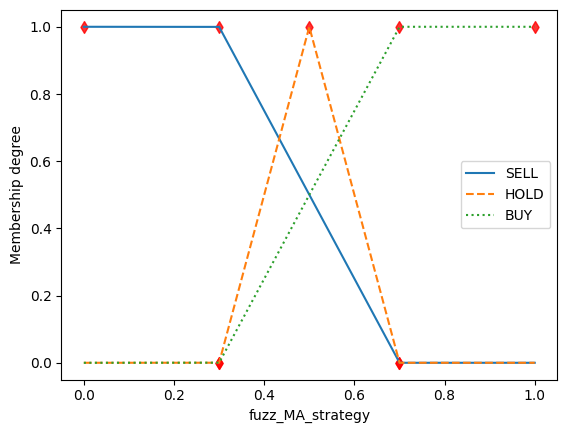

In [74]:
FS.plot_variable('fuzz_MA_strategy')

In [75]:
sp500['fuzz_MA_strategy'].value_counts()

fuzz_MA_strategy
BUY     806
SELL    433
Name: count, dtype: int64

## Backtesting

### ========

[Backtesting on github](https://github.com/kernc/backtesting.py/blob/master/backtesting/backtesting.py#L1014)
### ========

     `cash` is the initial cash to start with.

        `commission` is the commission ratio. E.g. if your broker's commission
        is 1% of trade value, set commission to `0.01`. Note, if you wish to
        account for bid-ask spread, you can approximate doing so by increasing
        the commission, e.g. set it to `0.0002` for commission-less forex
        trading where the average spread is roughly 0.2‰ of asking price.

        `margin` is the required margin (ratio) of a leveraged account.
        No difference is made between initial and maintenance margins.
        To run the backtest using e.g. 50:1 leverge that your broker allows,
        set margin to `0.02` (1 / leverage).

        If `trade_on_close` is `True`, market orders will be filled
        with respect to the current bar's closing price instead of the
        next bar's open.

        If `hedging` is `True`, allow trades in both directions simultaneously.
        If `False`, the opposite-facing orders first close existing trades in
        a [FIFO] manner.

        If `exclusive_orders` is `True`, each new order auto-closes the previous
        trade/position, making at most a single trade (long or short) in effect
        at each time.


In [76]:
sp500.tail()

,Date,Open,High,Low,Close,Volume,Name,Return,Up,Down,...,B_MA,BU,BL,prev_5MA,crossover,cross_MA,diff_MA,diff_MA_prev,MA_strategy,fuzz_MA_strategy
1234,2023-12-22,4753.92,4772.94,4736.77,4754.63,1.743793e+09,SP500,0.001659,0.001659,0.00000,...,4640.7610,4803.085413,4478.436587,4734.644,None,HOLD,75.272667,78.851333,HOLD,BUY
1235,2023-12-26,4758.86,4784.72,4758.45,4774.75,1.447991e+09,SP500,0.004223,0.004223,0.00000,...,4651.9770,4818.953936,4485.000064,4741.732,None,HOLD,68.446000,75.272667,HOLD,BUY
1236,2023-12-27,4773.45,4785.39,4768.90,4781.58,1.611193e+09,SP500,0.001429,0.001429,0.00000,...,4663.3115,4833.288462,4493.334538,4748.570,None,HOLD,56.794667,68.446000,HOLD,BUY
1237,2023-12-28,4786.44,4793.30,4780.98,4783.35,1.482519e+09,SP500,0.000370,0.000370,0.00000,...,4674.9500,4844.301427,4505.598573,4751.212,None,HOLD,58.194000,56.794667,HOLD,BUY
1238,2023-12-29,4782.88,4788.43,4751.99,4769.83,1.742503e+09,SP500,-0.002830,0.000000,0.00283,...,4685.0515,4851.569928,4518.533072,4768.212,None,HOLD,50.527333,58.194000,HOLD,BUY


## Fuzzy

In [77]:
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.set_index('Date')

In [17]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(sp500['fuzz_MA_strategy'] == 'BUY', 
                        sp500['fuzz_MA_strategy'] == 'SELL')

bt = Backtest(sp500, CustomStrategy, commission=0.01, exclusive_orders=True)
stats = bt.run()
bt.plot()


Row(id='1485', ...)

In [18]:
stats

Start                     2020-01-29 00:00:00
End                       2023-12-29 00:00:00
Duration                   1430 days 00:00:00
Exposure Time [%]                   52.755906
Equity Final [$]                  9994.502264
Equity Peak [$]                       10000.0
Return [%]                          -0.054977
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                   -0.013639
Volatility (Ann.) [%]                0.001065
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.054977
Avg. Drawdown [%]                   -0.054977
Max. Drawdown Duration     1400 days 00:00:00
Avg. Drawdown Duration     1400 days 00:00:00
# Trades                                  493
Win Rate [%]                         2.636917
Best Trade [%]                       0.848252
Worst Trade [%]                     -2.477263
Avg. Trade [%]                    

## Sharp

In [64]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(sp500['cross_MA'] == 'BUY', 
                        sp500['cross_MA'] == 'SELL')

bt = Backtest(sp500, CustomStrategy, commission=0.01, exclusive_orders=True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\AppData\Local\Temp\ipykernel_20848\385930944.py:7: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(at_eur_1h, CustomStrategy, commission=0.01, exclusive_orders=True)
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


Start                     2023-01-05 09:00:00
End                       2023-11-21 11:00:00
Duration                    320 days 02:00:00
Exposure Time [%]                   52.106055
Equity Final [$]                   9996.73875
Equity Peak [$]                       10000.0
Return [%]                          -0.032613
Buy & Hold Return [%]                1.754957
Return (Ann.) [%]                   -0.030666
Volatility (Ann.) [%]                0.001996
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.032614
Avg. Drawdown [%]                   -0.032614
Max. Drawdown Duration      306 days 16:00:00
Avg. Drawdown Duration      306 days 16:00:00
# Trades                                  303
Win Rate [%]                         0.660066
Best Trade [%]                       0.166712
Worst Trade [%]                      -2.24421
Avg. Trade [%]                    

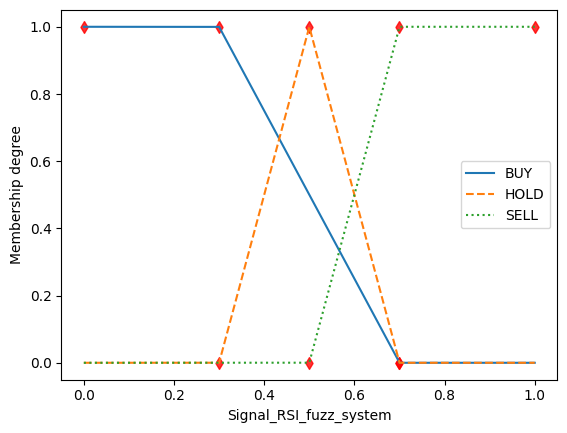

In [67]:
FS.plot_variable('Signal_RSI_fuzz_system')

# MACD

przy czym $T$ oznacza dzień, a $k$ to liczba dni, dla których należy obliczyć wykładniczą średnią ruchomą. Zgodnie z zasadami, gdy MACD przecina się powyżej linii sygnału, generowany jest sygnał kupna.


In [80]:
sp500['Signal_Line'] = sp500['MACD'].transform(lambda x: x.ewm(span=9, min_periods = 9, adjust=False).mean())


In [81]:

buy_condition = ((sp500['MACD'].shift(1) < sp500['Signal_Line'].shift(1)) & 
                 (sp500['MACD'] > sp500['Signal_Line']) |
                 ((sp500['MACD'] > sp500['Signal_Line']) & 
                  (sp500['MACD'] < sp500['Signal_Line']*1.1) &
                  (sp500['MACD'].shift(1) > sp500['Signal_Line'].shift(1)) & 
                  (sp500['MACD'].shift(1) < sp500['Signal_Line'].shift(1)*1.1)))

sell_condition = ((sp500['MACD'].shift(1) > sp500['Signal_Line'].shift(1)) & 
                  (sp500['MACD'] < sp500['Signal_Line']) |
                  ((sp500['MACD'] < sp500['Signal_Line']) & 
                   (sp500['MACD'] > sp500['Signal_Line']*0.9) &
                   (sp500['MACD'].shift(1) < sp500['Signal_Line'].shift(1)) & 
                   (sp500['MACD'].shift(1) > sp500['Signal_Line'].shift(1)*0.9)))

sp500['MACD_decision'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))


In [84]:
sp500['MACD_decision'].value_counts()

MACD_decision
 0    969
 1    152
-1    118
Name: count, dtype: int64

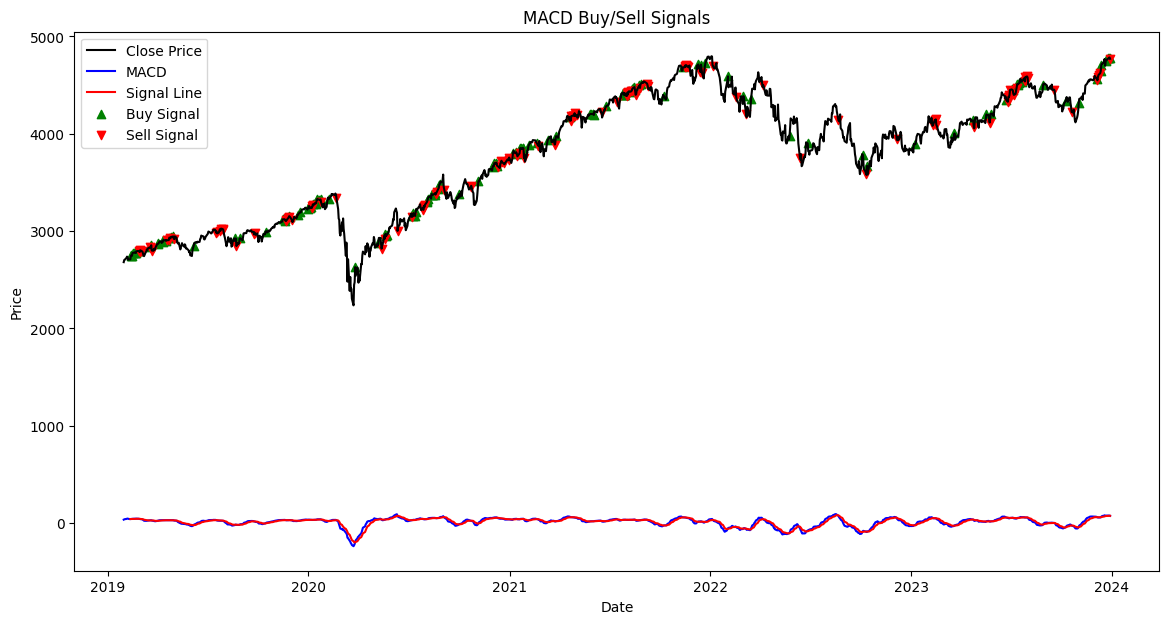

In [88]:

plt.figure(figsize=(14, 7))


plt.plot(sp500.index, sp500['Close'], label='Close Price', color='black')

plt.plot(sp500.index, sp500['MACD'], label='MACD', color='blue')
plt.plot(sp500.index, sp500['Signal_Line'], label='Signal Line', color='red')

buy_points = sp500[sp500['MACD_decision'] == 1]
sell_points = sp500[sp500['MACD_decision'] == -1]
plt.scatter(buy_points.index, buy_points['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_points.index, sell_points['Close'], marker='v', color='red', label='Sell Signal')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MACD Buy/Sell Signals')

plt.show()


In [19]:
sp500[['MACD', 'Signal_Line']].describe()

,MACD,Signal_Line
count,1239.000000,1239.000000
mean,11.502547,3766.898446
std,45.741658,619.558953
min,-237.020212,2467.245963
25%,-9.520942,3138.317699
50%,23.793992,3915.825618
75%,40.555642,4321.284844
max,92.583680,4761.725014


## `Fuzzy

In [19]:
   '''
    Linia MACD przetnie od dołu linię sygnałową - kup
    Linia MACD przetnie od góry linię sygnałową - sprzedaj
    '''
    
  #  Sygnał kupna jest generowany, gdy linia MACD przetnie linię sygnalną od dołu,
  #  a sygnał sprzedaży generowany jest wtedy, kiedy linia MACD przetnie linię sygnalną od góry.


# Calculating the difference between MACD and Signal line
sp500['diff_MACD'] = sp500['MACD'] - sp500['Signal_Line']

# Creation of 1 lagged column with the difference in MACD and Signal
sp500['diff_MACD_prev'] = sp500['diff_MACD'].shift(1)

'''
Ustalenie wartości 'małe', 'duże' na podstawie różnicy między MACD a linią sygnałową
i jej opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MACD około 0 i diff_MACD_prev < 0 - BUY
Jeśli diff_MACD około 0 i diff_MACD_prev > 0 - SELL
'''

threshold = 1.08 

sp500['MACD_decision'] = np.where((abs(sp500['diff_MACD']) < threshold) & (sp500['diff_MACD_prev'] < 0), 'BUY',
                                      np.where((abs(sp500['diff_MACD']) < threshold) & (sp500['diff_MACD_prev'] > 0), 'SELL', 'HOLD'))


In [80]:
Na dziennych zrobić ostre MACD i %R analogicznie do RSI


sp500['Signal_Line'] = sp500.groupby('Name')['Close'].transform(lambda x: x.ewm(span=9, adjust=False).mean())


sp500['diff_MACD'] = sp500['MACD'] - sp500['Signal_Line']

sp500['diff_MACD_prev'] = sp500['diff_MACD'].shift(1)

# kiedy następuje przecięcie
sp500['crossing'] = ((sp500['diff_MACD'] > 0) & (sp500['diff_MACD_prev'] < 0)) | ((sp500['diff_MACD'] < 0) & (sp500['diff_MACD_prev'] > 0))

# decyzja
sp500['MACD_decision'] = np.where((sp500['crossing']) & (sp500['diff_MACD'] > 0), 'BUY', 
                                      np.where((sp500['crossing']) & (sp500['diff_MACD'] < 0), 'SELL', 'HOLD'))


In [81]:
sp500['MACD_decision'].value_counts()

MACD_decision
HOLD    5318
Name: count, dtype: int64

In [63]:
sp500[['Signal_Line', 'MACD', 'diff_MACD']].describe()

,Signal_Line,MACD,diff_MACD
count,5318.000000,5318.000000,5318.000000
mean,1.080862,-0.000002,-1.080864
std,0.015935,0.001564,0.015676
min,1.047262,-0.009700,-1.124218
25%,1.068351,-0.000851,-1.092013
50%,1.081117,-0.000091,-1.081176
75%,1.092250,0.000719,-1.068253
max,1.124974,0.010653,-1.050476


jak wyniki złę to przesłać fragment z kilku decyzji backtestingu

Zmienić na dzinne

In [57]:
sp500[['Signal_Line', 'MACD']]

,Signal_Line,MACD
0,1.070810,0.000000
1,1.070788,-0.000009
2,1.069454,-0.000540
3,1.069340,-0.000571
4,1.069180,-0.000616
...,...,...
5313,1.069109,-0.000069
5314,1.069201,-0.000029
5315,1.068899,-0.000147
5316,1.069103,-0.000060


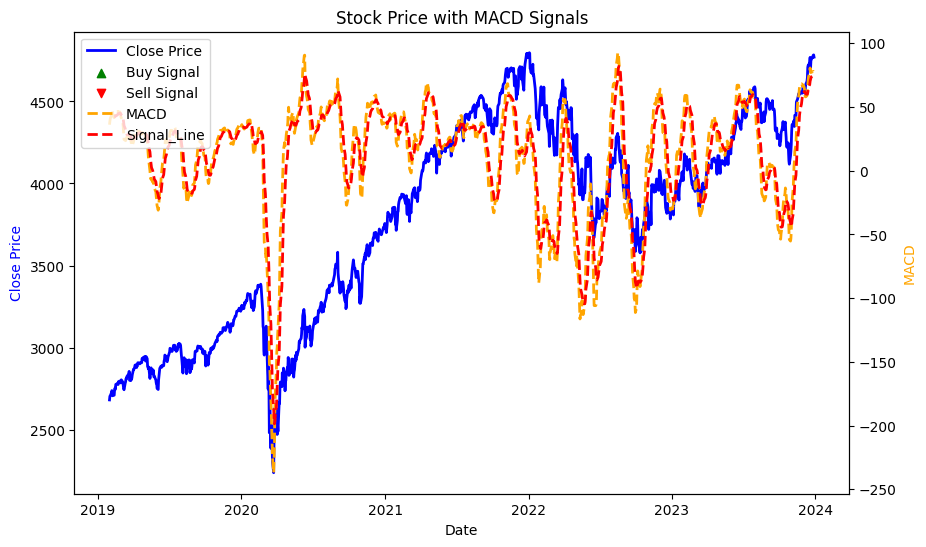

In [87]:
def plot_stock_data(data):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    data_sorted = data.sort_index()

    ax1.plot(data['Close'], label='Close Price', linewidth=2, color='blue')

    ax2 = ax1.twinx()
    ax2.plot(data['MACD'], label='MACD', linestyle='--', linewidth=2, color='orange')
    ax2.plot(data['Signal_Line'], label='Signal_Line', linestyle='--', linewidth=2, color='red')


    ax1.scatter(data.index[data['MACD_decision'] == 'BUY'], data['Close'][data['MACD_decision'] == 'BUY'],
                marker='^', color='g', label='Buy Signal', alpha=1)
    ax1.scatter(data.index[data['MACD_decision'] == 'SELL'], data['Close'][data['MACD_decision'] == 'SELL'],
                marker='v', color='r', label='Sell Signal', alpha=1)

    ax1.set_title('Stock Price with MACD Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='blue')
    ax2.set_ylabel('MACD', color='orange')

    # Łączny legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()


plot_stock_data(sp500)


In [ ]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [0, 1.], [0.0002, 0.]], term="low")
S2 = sf.FuzzySet(points=[[0, 0.], [0.0002, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MACD", LV)

# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MACD_strategy", LV)

R1 = "IF (diff_MACD IS low) THEN (fuzz_MACD_strategy IS BUY)"
R2 = "IF (diff_MACD IS high) THEN (fuzz_MACD_strategy IS SELL)"
FS.add_rules([R1, R2])

sp500['fuzz_MACD_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(sp500['MACD']):
    FS.set_variable("diff_MACD", value)
    decision = FS.Mamdani_inference()['fuzz_MACD_strategy']
    
    if decision <= 0.3:
        sp500.loc[sp500.index[i], 'fuzz_MACD_strategy'] = 'BUY'
    elif decision >= 0.7:
        sp500.loc[sp500.index[i], 'fuzz_MACD_strategy'] = 'SELL'
